In [9]:
!ls

KC_sandbox01.ipynb  sample_submission.csv  test.csv  train.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import statsmodels.api as sm

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier

In [3]:
train_file = pd.read_csv(r'train.csv')
train_file.head()

,id,gravity,ph,osmo,cond,urea,calc,target
0,0,1.013,6.19,443,14.8,124,1.45,0
1,1,1.025,5.40,703,23.6,394,4.18,0
2,2,1.009,6.13,371,24.5,159,9.04,0
3,3,1.021,4.91,442,20.8,398,6.63,1
4,4,1.021,5.53,874,17.8,385,2.21,1


In [4]:
test_file = pd.read_csv(r'test.csv')
test_file.head()

,id,gravity,ph,osmo,cond,urea,calc
0,414,1.017,5.24,345,11.5,152,1.16
1,415,1.020,5.68,874,29.0,385,3.46
2,416,1.024,5.36,698,19.5,354,13.00
3,417,1.020,5.33,668,25.3,252,3.46
4,418,1.011,5.87,567,29.0,457,2.36


In [10]:
train_file.drop('id', axis = 1, inplace = True)
test = test_file.drop('id', axis = 1)

/tmp/ipykernel_109/1977034783.py:28: RuntimeWarning: divide by zero encountered in log
  plt.plot(x, np.log(x))


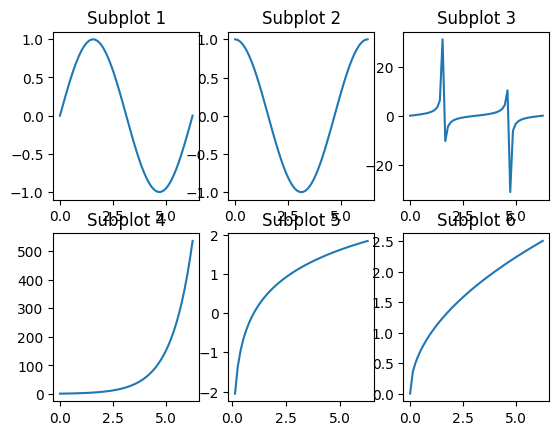

In [21]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(2, 1, figsize=(8, 10))
x = np.linspace(0, 2*np.pi, 50)

# create the first subplot
plt.subplot(2, 3, 1)
plt.plot(x, np.sin(x))
plt.title('Subplot 1')

# create the second subplot
plt.subplot(2, 3, 2)
plt.plot(x, np.cos(x))
plt.title('Subplot 2')

# create the third subplot
plt.subplot(2, 3, 3)
plt.plot(x, np.tan(x))
plt.title('Subplot 3')

# create the fourth subplot
plt.subplot(2, 3, 4)
plt.plot(x, np.exp(x))
plt.title('Subplot 4')

# create the fifth subplot
plt.subplot(2, 3, 5)
plt.plot(x, np.log(x))
plt.title('Subplot 5')

# create the sixth subplot
plt.subplot(2, 3, 6)
plt.plot(x, np.sqrt(x))
plt.title('Subplot 6')

plt.show()


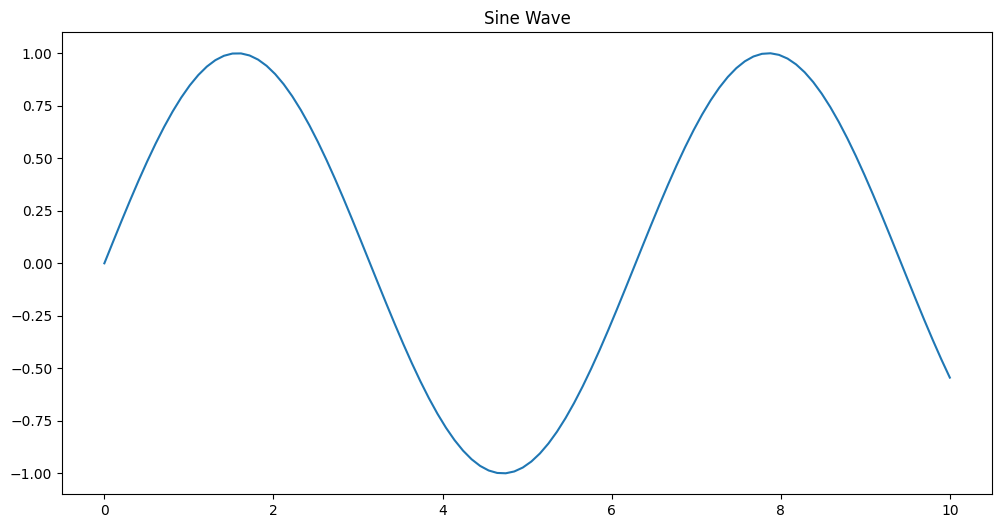

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# create a figure object with a size of 8x6 inches
fig = plt.figure(figsize=(12, 6))

# define the x values
x = np.linspace(0, 10, 100)

# define the y values
y = np.sin(x)

# create a plot of y versus x
plt.plot(x, y)

# set the title of the plot
plt.title('Sine Wave')

# show the plot
plt.show()


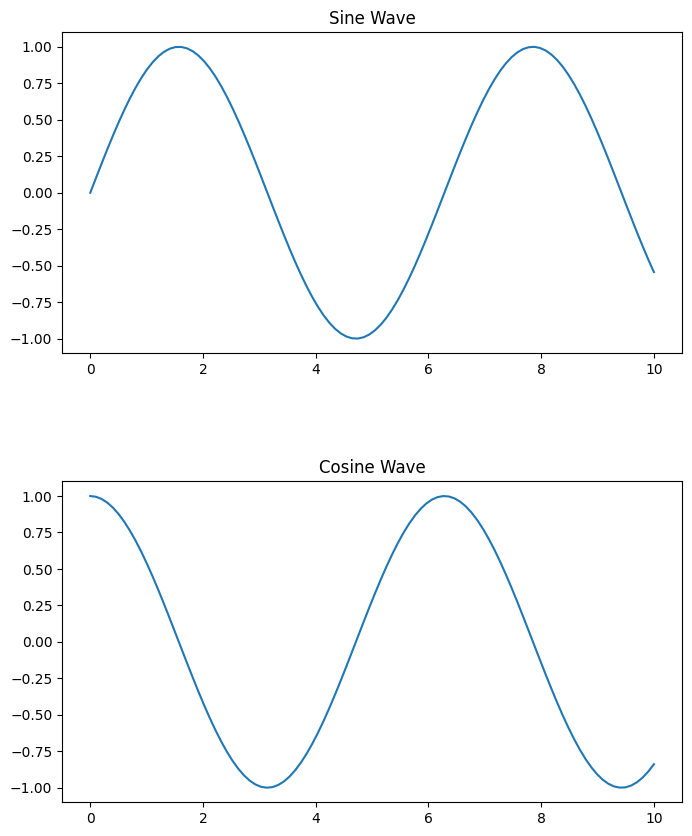

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# create a figure object with a size of 8x6 inches and 2 subplots
fig, axs = plt.subplots(2, 1, figsize=(8, 10))

# define the x values
x = np.linspace(0, 10, 100)

# define the y values for the first subplot
y1 = np.sin(x)

# create a plot of y1 versus x in the first subplot
axs[0].plot(x, y1)
axs[0].set_title('Sine Wave')

# define the y values for the second subplot
y2 = np.cos(x)

# create a plot of y2 versus x in the second subplot
axs[1].plot(x, y2)
axs[1].set_title('Cosine Wave')

# adjust the spacing between the subplots
plt.subplots_adjust(hspace=0.4)

# show the plot
plt.show()


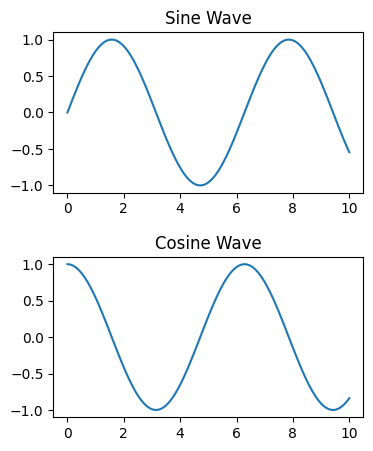

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# create a figure object with a size of 8x6 inches and 2 subplots
fig, axs = plt.subplots(2, 1, figsize=(4,5))

# define the x values
x = np.linspace(0, 10, 100)

# define the y values for the first subplot
y1 = np.sin(x)

# create a plot of y1 versus x in the first subplot
axs[0].plot(x, y1)
axs[0].set_title('Sine Wave')

# define the y values for the second subplot
y2 = np.cos(x)

# create a plot of y2 versus x in the second subplot
axs[1].plot(x, y2)
axs[1].set_title('Cosine Wave')

# adjust the spacing between the subplots
plt.subplots_adjust(hspace=0.4)

# show the plot
plt.show()
